In [16]:
import os
import numpy as np
import scipy.io as sio
import scipy.stats as sp_stats
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

# 1. Laplacian Matrix

In [2]:
## 1.1 Load required data
# group-level structural connectivity matrix
W = sio.loadmat('./data/SC_avg56.mat')['SC_avg56']

# individual-level functional time series
X_RS = sio.loadmat('./data/X_RS_10subjects.mat')['X_RS']

# Number of regions
n_ROI = W.shape[0]

# Number of subjects in demo data
nsubjs_RS = X_RS.shape[-1]

print(W.shape, X_RS.shape)
print(n_ROI, nsubjs_RS)

(360, 360) (360, 1190, 10)
360 10


In [3]:
## 1.2 Z-score fMRI time courses
zX_RS = sp_stats.zscore(X_RS, axis=1)

In [4]:
## 1.3 Symmetric normalization
degree = W.sum(axis=1)
D = np.diag( degree )
tmp = np.diag(degree**(-0.5))
Wsymm = tmp.dot(W).dot(tmp)
Wnew = Wsymm.copy()

In [5]:
## 1.4 compute normalised Laplacian matrix
L = np.identity(n_ROI) - Wnew

In [52]:
## 1.5 Laplacian decomposition
lambdaL, U = np.linalg.eig(L)
IndL = np.argsort(lambdaL)
lambdaL = lambdaL[IndL]
U = U[:, IndL]

In [7]:
## Compute weighted zero crossings
wZC = []
for u in range(U.shape[1]):
    UU = U[:, u]
    summ = 0
    for i in range(len(UU)-1):
        for j in range(i+1, len(UU)):
            if UU[i]*UU[j] < 0:
                summ += (W[i, j] > 1)
    wZC.append(summ)

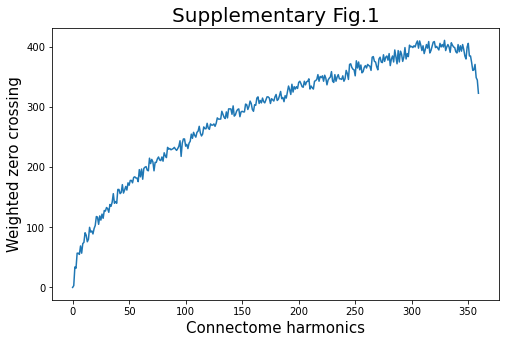

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(wZC)
plt.title("Supplementary Fig.1", size = 20)
plt.xlabel("Connectome harmonics", size=15)
plt.ylabel("Weighted zero crossing", size=15)
plt.show()
plt.close()

In [40]:
## Average energy spectral density
X_hat_L = np.empty(shape=zX_RS.shape)
for s in range(nsubjs_RS):
    X_hat_L[:, :, s] = np.dot(U.T, zX_RS[:, :, s])
pow = np.abs(X_hat_L) ** 2
PSD = np.mean(pow, axis=1)

avg = PSD.mean(axis=1)
stdPSD = PSD.std(axis=1)
upper1 = avg + stdPSD
lower1 = avg - stdPSD

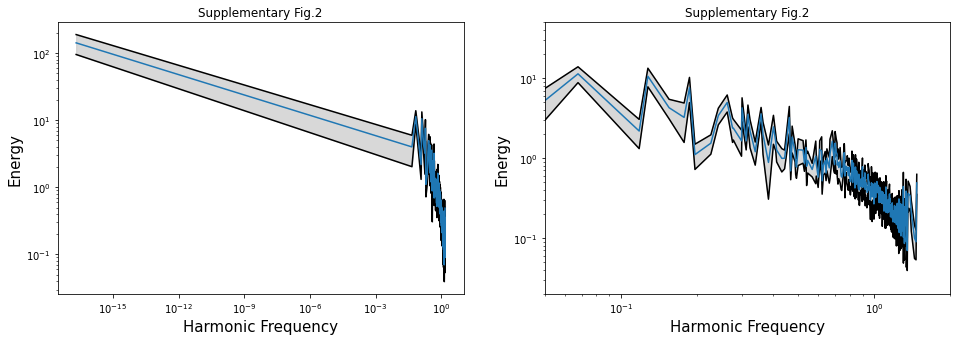

In [67]:
idx = ( PSD.max(axis=1) > 0 ) & ( PSD.min(axis=1) > 0 ) & ( PSD.min(axis=1) > 0 )

plt.figure(figsize=(16, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.fill_between(lambdaL[idx], lower1, upper1, alpha=0.3, color='grey')
    plt.plot(lambdaL, lower1, color='black')
    plt.plot(lambdaL, upper1, color='black')
    plt.plot(lambdaL, avg)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Supplementary Fig.2')
    plt.xlabel('Harmonic Frequency', size=15)
    plt.ylabel('Energy', size=15)
    if i==1:
        plt.xlim(0.05, 2)
        plt.ylim(0.02, 50)
plt.show()
plt.close()

In [95]:
## 1.6 compute cut-off frequency
mPSD = np.mean(PSD, axis=1)
step_increment = ((mPSD[:-1] + mPSD[1:])/2).cumsum()
thr = step_increment[-1] / 2 
NN = (step_increment > thr).argmax()+2
NNL = mPSD.shape[0] - NN

M = U[:, ::-1]
Vlow = np.zeros(shape=M.shape)
Vhigh = np.zeros(shape=M.shape)
Vlow[:, NNL:] = M[:, NNL:]    # low frequencies is coupled
Vhigh[:, :NNL] = M[:, :NNL]  # high frequencies is decoupled


# 2. Graph signal analysis

In [102]:
data = zX_RS

In [116]:
## compute fMRI HF/LF portions
N_c = np.empty(shape=(n_ROI, nsubjs_RS))
N_d = np.empty(shape=(n_ROI, nsubjs_RS))

for s in range(zX_RS.shape[-1]):
    X_hat = np.dot(M.T, data[:, :, s])
    X_c = Vlow.dot(X_hat)
    X_d = Vhigh.dot(X_hat)
    
    N_c[:, s] = np.linalg.norm(X_c, axis=1)
    N_d[:, s] = np.linalg.norm(X_d, axis=1)

mean_c = N_c.mean(axis=1)
mean_d = N_d.mean(axis=1)
        

# 3. Create SC-informed graph signal surrogates

In [125]:
nSurr = 19 # generate 19 surrogates

In [156]:
## spatial randomization
XrandS = []
storage_size = (data.shape[0], data.shape[1], nSurr)
for s in range(data.shape[-1]):
    X = data[:, :, s]
    XrandS.append( np.empty(shape=storage_size) )
    for n in range(nSurr):
        PHIdiag = np.random.randint(0, 2, size=M.shape[0])
        PHIdiag[PHIdiag==0] = -1
        PHI = np.diag(PHIdiag)
        XrandS[s][:, :, n] = M.dot(PHI).dot(M.T).dot(X)

# 4. compute structural decoupling index (SDI)

In [157]:
fdata = XrandS

N_c_surr = np.empty(shape=(n_ROI, nSurr, nsubjs_RS))
N_d_surr = np.empty(shape=(n_ROI, nSurr, nsubjs_RS))

for s in range(len(fdata)):                   # for each subject
    for i in range(fdata[0].shape[-1]):       # for each surrogate
        X_hat_surr = np.dot(M.T, fdata[s][:, :, i])
        X_c_surr = Vlow.dot(X_hat_surr)
        X_d_surr = Vhigh.dot(X_hat_surr)
        
        N_c_surr[:, i, s] = np.linalg.norm(X_c_surr, axis=1)
        N_d_surr[:, i, s] = np.linalg.norm(X_d_surr, axis=1)

In [173]:
## SDI for surrogate data
SDI_surr = N_d_surr / N_c_surr   # SDI for every subjects and surrogates
SDI_surr_avgsurr = SDI_surr.mean(axis=1)
SDI_surr_avgsurrsubjs = SDI_surr_avgsurr.mean(axis=1)


In [165]:
## SDI for empirical data
SDI = N_d / N_c
mean_SDI = mean_d / mean_c


# 4.1 select significant SDI

In [225]:
## individual threshold, first screening
max_SDI_surr = SDI_surr.max(axis=1)
min_SDI_surr = SDI_surr.min(axis=1)
detect_max = (SDI > max_SDI_surr).sum(axis=1)
detect_min = (SDI < min_SDI_surr).sum(axis=1)

In [235]:
## For each region, test across subjects 0.05, correcting for the number of tests (regions, N=360) 0.05/360
x = np.arange(0, 101, 1)
y = sp_stats.binom.cdf(x[::-1], 100, 0.95)
y[:-1] = y[1:]
y[-1] = 0

THRsubjects = x[np.where(y<0.05/360)[0].min()]
THRsubjects = np.floor(nsubjs_RS/100 * THRsubjects) + 1

SDI_sig_higher = detect_max > THRsubjects
SDI_sig_lower  = detect_min > THRsubjects
SDI_sig_higher_position = np.where(SDI_sig_higher==1)[0]
SDI_sig_lower_position  = np.where(SDI_sig_lower==1)[0]
SDI_sig_tot_position = np.unique(np.hstack((SDI_sig_higher_position, SDI_sig_lower_position)))

In [237]:
## threshold empirical mean ratios
mean_SDI_thr = np.ones(n_ROI)
mean_SDI_thr[SDI_sig_tot_position] = mean_SDI[SDI_sig_tot_position]

In [276]:
## vistualization (emprical data)

# 1. scale color range and size range
CC2 = np.log2(mean_SDI_thr)
thr = 1
CC2new = CC2.copy()
CC2new[CC2>thr] = 0
CC2new[CC2>thr] = CC2new.max()
thr = -1
CC2new[CC2<thr] = 0
CC2new[CC2<thr] = CC2new.min()
CC2 = CC2new
CC = np.abs(CC2)

# 2. get coordinate
coords = np.hstack( sio.loadmat('./data/Glasser360_2mm_codebook.mat')['codeBook'][0, 0][-2][0] ).T

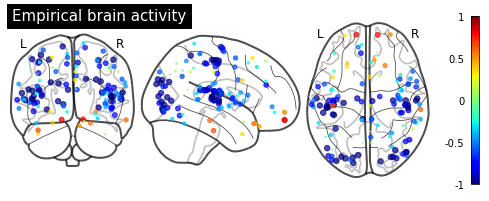

In [349]:
plotting.plot_markers(CC2, coords, node_size=CC*30, 
                      node_cmap = plt.cm.jet, 
                      node_vmin = -1, node_vmax=1, 
                      title = "Empirical brain activity")
plotting.show()

# 5. Functional connectivity analysis

In [354]:
## empirical data
CSpacereal = np.empty(shape=(n_ROI, n_ROI, nsubjs_RS))
for i in range(nsubjs_RS):
    CSpacereal[:, :, i] = np.corrcoef(zX_RS[:, :, i])
mean_CSpacereal = CSpacereal.mean(axis=2)

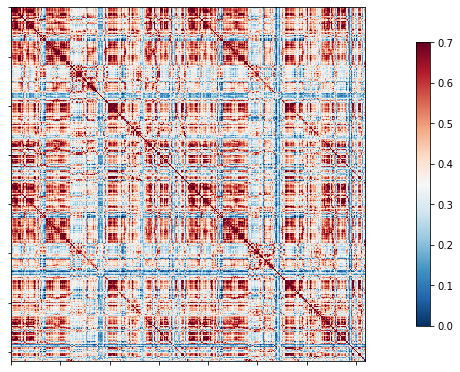

In [360]:
plotting.plot_matrix(mean_CSpacereal, vmin=0., vmax=0.7)
plotting.show()

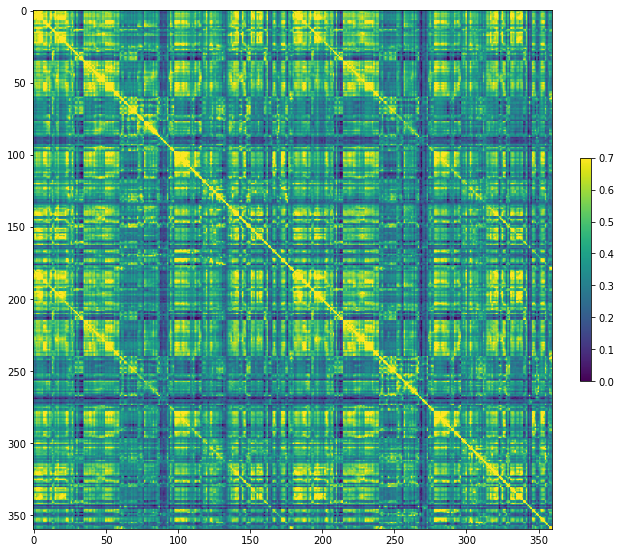

In [372]:
plt.figure(figsize=(10, 10))
plt.imshow(mean_CSpacereal, vmin=0, vmax=0.7)
plt.colorbar(fraction=0.02, pad=0.05)
plt.show()
plt.close()

# 6. Neurosynth meta-analysis

## 6.1 Create maps

In [506]:
if not os.path.exists('./my_masks'):
    os.mkdir('./my_masks')

refnii = nib.load('./data/HCP-MMP1_onMNI152_2mm_Glasser360.nii')
refnii_fdata = np.floor(refnii.get_fdata()+0.5)
split_bins = np.percentile(mean_SDI, np.linspace(0, 100, num=21, endpoint=True))
for i in range(split_bins.shape[0]-1):
    thr1, thr2 = split_bins[i:i+2]
    NSvecs = np.logical_and(mean_SDI>thr1, mean_SDI<=thr2)
    f = np.where(NSvecs)[0] + 1
    
    NSmaps = np.zeros(refnii.shape)
    NSmaps[np.isin(refnii_fdata, f)] = 1
    nib.Nifti2Image(NSmaps, refnii.affine).to_filename('./my_masks/56subjs_SDI_%02d.nii'%(i+1))

## 6.2 meta analysis

In [2]:
from neurosynth import Dataset
from neurosynth import decode
import pandas as pd

In [ ]:
#dataset = Dataset('./data/database.txt')
#dataset.add_features('./data/features.txt')
#dataset.save('./data/dataset.pkl')

In [3]:
dataset=Dataset.load('./data/dataset.pkl')
features = pd.read_csv('./data/v3-topics-50.txt', sep='\t', index_col=0)
topics_to_keep = [ 1, 4,  6, 14, 
                  18, 19, 23, 25, 
                  20, 21, 27, 29,
                  30, 31, 33, 35, 
                  36, 38, 37, 41, 
                  44, 45, 48, 49]
labels = ['face/affective processing', ' verbal semantics', 'cued attention', 'working memory', 
          'autobiographical memory', 'reading', 'inhibition', 'motor', 
          'visual perception', 'numerical cognition', 'reward-based decision making', 'visual attention', 
          'multisensory processing', 'visuospatial','eye movements', 'action',
          'auditory processing', 'pain', 'language', 'declarative memory', 
          'visual semantics', 'emotion', 'cognitive control', 'social cognition']
features = features.iloc[:, topics_to_keep]
features.columns = labels
dataset.add_features(features, append=False)

In [8]:
path = './my_masks/'
roi_list = [ path+i for i in os.listdir('./my_masks') ]

decoder = decode.Decoder(dataset, method='roi')
data = decoder.decode(roi_list, save='decoding_results_SDI_56subjs_.txt')

In [37]:
data.columns = [ f'{i*5}-{(i+1)*5}' for i in range(20) ]


thr = 3.1
df = data.copy()
df[df<thr] = 0


In [106]:
dh = (df.to_numpy() * np.arange(1, 21)).sum(axis=1) / df.to_numpy().sum(axis=1)
heatmapOrder = np.argsort(dh)
plotData = df.reindex(df.index[heatmapOrder])

In [107]:
from matplotlib.ticker import AutoMinorLocator

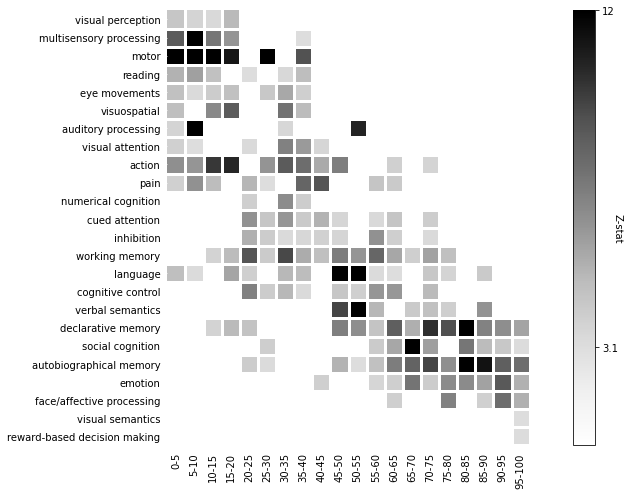

In [132]:
fig, ax = plt.subplots(figsize=(15, 8))

im = ax.imshow(plotData, cmap=plt.cm.Greys, vmin=0.5, vmax=12)

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
ax.grid(which="minor", color="white", zorder=10, linewidth=3)

for key in ['left', 'right', 'top', 'bottom']:
    ax.spines[key].set_visible(False)
#ax.tick_params(which="both", bottom=False, top=False, left=False, right=False)  # 去除刻度
ax.tick_params(which="both", color="w")
ax.set_xlim(-0.5, 19.6)

ax.set_xticks(np.arange(20))
ax.set_xticklabels(plotData.columns, rotation=90)
ax.set_yticks(np.arange(24))
ax.set_yticklabels(plotData.index)

cb =fig.colorbar(im, ax=ax, fraction=0.1, pad=0.05)
cb.set_label('Z-stat', rotation=270)
cb.set_ticks([3.1, 12])
cb.set_ticklabels([3.1, 12])
plt.show()
plt.close()